## self-rag LangGraph例子

In [22]:
! pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

In [23]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownHeaderTextSplitter
import uuid
import os


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
# LangSmith 项目名称，默认 default
os.environ["LANGCHAIN_PROJECT"] = "default"

In [24]:
file_path = os.path.join('data', 'data.md')
with open(file_path, 'r', encoding='utf-8') as file:
    docs_string = file.read()

# Split the document into chunks base on markdown headers.
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
doc_splits = text_splitter.split_text(docs_string)

# Add to vectorDB
random_directory = "./" + str(uuid.uuid4())
embedding = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key="sk-T6SlqfUnyFytejvA3c1584F87d6343878232185e26243b1d",openai_api_base="https://api.apiyi.com/v1")
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embedding, persist_directory=random_directory, collection_name="rag-chroma",)
retriever = vectorstore.as_retriever()

In [25]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


In [26]:
class GradeDocuments(BaseModel):
  binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

llm = ChatOpenAI(
    model="gpt-4o-mini", temperature=0,
    api_key="sk-T6SlqfUnyFytejvA3c1584F87d6343878232185e26243b1d",
    base_url="https://api.apiyi.com/v1"
)

structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """您是一名评分员，负责评估检索到的文档与用户问题的相关性。\n
测试不需要很严格。目标是过滤掉错误的检索。\n
如果文档包含与用户问题相关的关键字或语义含义，则将其评为相关。\n
给出二进制分数“yes”或“no”，以指示文档是否与问题相关。"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader


In [27]:
# 相关问题
question = "西安天气怎么样"

docs = retriever.get_relevant_documents(question)
# 观察每一个文档块的相关性判断结果
for doc in docs:
    print("doc: \n", doc.page_content, "\n")
    print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
    print("\n")


doc: 
 - **技术支持**: support@example.com
- **紧急联系**: emergency@example.com
- **客服热线**: 123-456-7890 

binary_score='no'


doc: 
 - **代码优化**: 定期审查代码，优化算法和逻辑。
- **资源扩展**: 根据业务增长，适时扩展系统资源。
- **负载均衡**: 使用负载均衡技术，分散请求压力。 

binary_score='no'


doc: 
 - **数据备份**: 定期备份数据库和重要文件，确保数据安全。
- **系统更新**: 定期更新系统和软件，修复已知漏洞。
- **性能调优**: 定期检查系统性能，进行必要的优化。 

binary_score='no'


doc: 
 - **访问控制**: 严格控制系统访问权限，实行最小权限原则。
- **数据加密**: 对敏感数据进行加密处理，保护用户隐私。
- **安全审计**: 定期进行安全审计，检查潜在的安全风险。 

binary_score='no'




In [46]:
# 相关问题
# question = "payment 服务是谁维护的"
question = "谁管理的服务数量最多？"
docs = retriever.get_relevant_documents(question)
# 观察每一个文档块的相关性判断结果
for doc in docs:
    print("doc: \n", doc.page_content, "\n")
    print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
    print("\n")


doc: 
 - **交易量**: 监控每秒交易数，确保系统承载能力。
- **响应时间**: 监控交易的平均响应时间，确保服务性能。
- **系统负载**: 监控CPU、内存等资源使用率，避免资源瓶颈。 

binary_score='no'


doc: 
 - **代码优化**: 定期审查代码，优化算法和逻辑。
- **资源扩展**: 根据业务增长，适时扩展系统资源。
- **负载均衡**: 使用负载均衡技术，分散请求压力。 

binary_score='no'


doc: 
 - **问题描述**: 用户支付请求处理时间超过正常范围。
- **可能原因**:
- 系统资源不足
- 数据库查询效率低下
- 外部服务响应慢
- **解决办法**:
- 增加系统资源，如CPU、内存。
- 优化数据库查询，使用索引，减少复杂查询。
- 与外部服务提供商沟通，优化接口性能。 

binary_score='no'


doc: 
 - **技术支持**: support@example.com
- **紧急联系**: emergency@example.com
- **客服热线**: 123-456-7890 

binary_score='no'




In [37]:
question = "谁负责的服务数量最多？"
docs = retriever.get_relevant_documents(question)
# 观察每一个文档块的相关性判断结果
for doc in docs:
    print("doc: \n", doc.page_content, "\n")
    print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
    print("\n")

doc: 
 - **交易量**: 监控每秒交易数，确保系统承载能力。
- **响应时间**: 监控交易的平均响应时间，确保服务性能。
- **系统负载**: 监控CPU、内存等资源使用率，避免资源瓶颈。 

binary_score='no'


doc: 
 - **技术支持**: support@example.com
- **紧急联系**: emergency@example.com
- **客服热线**: 123-456-7890 

binary_score='no'


doc: 
 - **问题描述**: 用户支付请求处理时间超过正常范围。
- **可能原因**:
- 系统资源不足
- 数据库查询效率低下
- 外部服务响应慢
- **解决办法**:
- 增加系统资源，如CPU、内存。
- 优化数据库查询，使用索引，减少复杂查询。
- 与外部服务提供商沟通，优化接口性能。 

binary_score='no'


doc: 
 - **代码优化**: 定期审查代码，优化算法和逻辑。
- **资源扩展**: 根据业务增长，适时扩展系统资源。
- **负载均衡**: 使用负载均衡技术，分散请求压力。 

binary_score='no'




In [38]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

我不知道。


In [39]:
# 评估LLM 的回答是否基于事实（文档）
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

structured_llm_grader1 = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """您是一名评分员，正在评估 LLM 生成是否基于一组检索到的事实/由一组检索到的事实支持。\n
给出二进制分数“yes”或“no”。 “yes”表示答案基于一组事实/由一组事实支持。"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader1
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='no')

In [40]:
### 评估 LLM 的回答是否解决了用户问题

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

structured_llm_grader2 = llm.with_structured_output(GradeAnswer)
system = """您是评分员，评估答案是否解决某个问题 \n
给出二进制分数“yes”或“no”。“yes”表示答案解决了问题。"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader2
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='no')

In [41]:
### 结合知识库，重写问题

# Prompt
system = """您有一个问题重写器，可将输入问题转换为针对 vectorstore 检索进行了优化的更好版本 \n
。查看输入并尝试推断底层语义意图/含义，使用用户语言回复。"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'哪个人或组织提供的服务数量最多？'

In [42]:
## 构造agent

from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  question: str
  generation: str
  documents: List[str]


In [43]:
## 检索文档

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


# 生成回复
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

# 判断检索到的文档是否和问题相关
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("----检查文档是否和问题相关----\n")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("文档和用户问题相关\n")
            filtered_docs.append(d)
        else:
            print("文档和用户问题不相关\n")
            continue
    return {"documents": filtered_docs, "question": question}

# 改写问题，生成更好的问题
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("改写问题\n")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("LLM 改写优化后更好的提问：", better_question)
    return {"documents": documents, "question": better_question}

### Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("访问检索到的相关知识库\n")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("所有的文档都不相关，重新生成问题\n")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("文档和问题相关，生成回答")
        return "generate"

# 评估生成的回复是否基于知识库事实（是否产生了幻觉）
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("评估生成的回复是否基于知识库事实（是否产生了幻觉）\n")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("生成的回复是基于知识库，没有幻觉\n")
        # 评估LLM 的回答是否解决了用户问题
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("问题得到解决\n")
            return "useful"
        else:
            print("问题没有得到解决\n")
            return "not useful"
    else:
        print("生成的回复不是基于知识库，继续重试……\n")
        return "not supported"

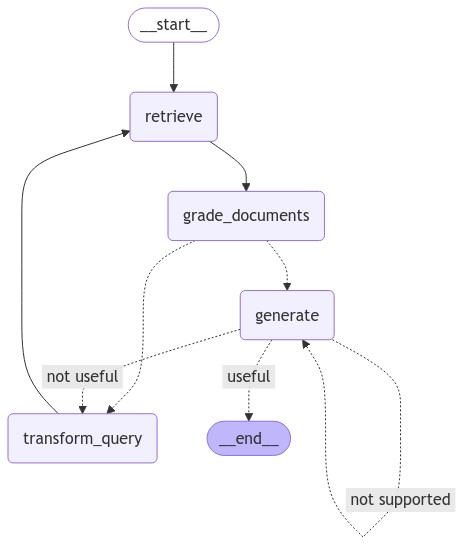

In [35]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display


file_path = os.path.join('data', 'data.md')


workflow = StateGraph(GraphState)

# 添加 Nodes
workflow.add_node("retrieve", retrieve)  # 检索文档
workflow.add_node("grade_documents", grade_documents)  # 判断检索到的文档是否和问题相关
workflow.add_node("generate", generate)  # 生成回复
workflow.add_node("transform_query", transform_query)  # 改写问题，生成更好的问题

# 生成有向有环图
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
# 给 grade_documents 添加条件边，判断 decide_to_generate 函数返回的结果
# 如果函数返回 "transform_query"，则跳转到 transform_query 节点
# 如果函数返回 "generate"，则跳转到 generate 节点
workflow.add_conditional_edges(
    "grade_documents",
    # 条件：评估检索到的文档是否和问题相关，如果不相关则重新检索，如果相关则生成回复
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
# 给 generate 添加条件边，判断 grade_generation_v_documents_and_question 函数返回的结果
# 如果函数返回 "useful"，则跳转到 END 节点
# 如果函数返回 "not useful"，则跳转到 transform_query 节点
# 如果函数返回 "not supported"，则跳转到 generate 节点
workflow.add_conditional_edges(
    "generate",
    # 条件：评估生成的回复是否基于知识库事实（是否产生了幻觉），是则评估答案准确性，否则重新生成问题
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)
# Compile
app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [36]:
from pprint import pprint

# 简单问题
# inputs = {"question": "payment_backend服务是谁维护的？"}
# 复杂问题
inputs = {"question": "谁管理的服务数量最多？"}

for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
----检查文档是否和问题相关----

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

访问检索到的相关知识库

所有的文档都不相关，重新生成问题

"Node 'grade_documents':"
'\n---\n'
改写问题

LLM 改写优化后更好的提问： 哪个组织或个人管理的服务数量最多？
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
----检查文档是否和问题相关----

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

访问检索到的相关知识库

所有的文档都不相关，重新生成问题

"Node 'grade_documents':"
'\n---\n'
改写问题

LLM 改写优化后更好的提问： 哪个组织或个人提供的服务数量最多？
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
----检查文档是否和问题相关----

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

访问检索到的相关知识库

所有的文档都不相关，重新生成问题

"Node 'grade_documents':"
'\n---\n'
改写问题

LLM 改写优化后更好的提问： 哪个组织或个人提供的服务种类和数量最多？
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
----检查文档是否和问题相关----

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

文档和用户问题不相关

访问检索到的相关知识库

所有的文档都不相关，重新生成问题

"Node 'grade_documents':"
'\n---\n'
改写问题

LLM 改写优化后更好的提问： 哪个组织或个人提供的服务种类和数量最多？请提供具体的比

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.